# Load Data

In [101]:
import pandas as pd
import numpy as np
from scipy import stats

choice_data_dprime_threeRounds=np.load('data_dprime_cleaned.npy')
choice_data_dprime_threeRounds=(choice_data_dprime_threeRounds-np.mean(choice_data_dprime_threeRounds))/np.std(choice_data_dprime_threeRounds)

print('averages across conditions:\n baseline:    unpopular:     popular:')
print(np.mean(np.mean(choice_data_dprime_threeRounds,axis=0),axis=1))


likeable_threegroups=np.load('likeable_subs_allthree.npy')
likeable_threegroups=likeable_threegroups+1 # rescale to 0,1,2 encoding 

print('Number subjects: {}'.format(num_subjects))

averages across conditions:
 baseline:    unpopular:     popular:
[-0.18349739  0.04233689  0.1411605 ]
Number subjects: 129


In [86]:
print(np.sum(likeable_binary))
print(len([x for x in likeable_no_equals if x==0]))
print(len([x for x in likeable_no_negs if x==0]))

print(64+23+42)

64
23
42
129


# Calculate scaled priors

In [10]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

ySD=np.std(choice_data_dprime_threeRounds)
yMean=np.mean(choice_data_dprime_threeRounds)
gammas, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
bl_sd=1/((ySD*5)**2)
print(bl_sd)
noise=[ySD/100,ySD*10]
print(noise)
print(gammas)
print(rate)




0.04
[0.01, 10.0]
1.2831955546343297
0.5663911092686593


In [21]:
print(len(likeable_no_equals))
print(len(choice_data_dprime_threeRounds_r))

87
87


# Model: condition, subject, group & interaction of group and condition

#### For model below, i=condition, j=subject, k=block,g=group

$data_{i,k,j} \sim \mathcal{N}(theta_{i,k,j},noise)$

$noise \sim U(0.01,10)$ Error term

$\theta_{i,k,j}= baseline+subjectIntercept_{j}+groupEffect_{g}+conditionEffect_{i}+Interaction_{g,i}$

$subjectIntercept_{j} \sim \mathcal{N}(\mu_{data},\sigma_{subject})$

$baseline \sim \mathcal{N}(0,5)$

$\sigma_{subject} \sim U(0,\sigma_{S})$

$ConditionEffect \sim \mathcal{N}(0,\sigma_{W})$

$groupEffect \sim \mathcal{N}(0,\sigma_{B})$

$Interaction \sim \mathcal{N}(0,\sigma_{BxW})$

$\sigma_{all} \sim \mathcal{G}(1.28,0.56)$


 # A priori value model

In [91]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> liks[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  real<lower=0.00001> sigmaW;

  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (liks[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1];
            theta_popular[k] = a0+aS[k]+aCondition[2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3];
            }
        else if (liks[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1];
            theta_popular[k] = a0+aS[k]+aCondition[2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3];
        }
        }
    
}
model {    
    
    
    sigmaW ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    aCondition ~ normal(0,sigmaW);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.10);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds,#choice data
              'NxConditions':3,
              'NxSubjects':129,
              'NxBlocks':3, 
              'liks':likeable_binary
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aef255d91b0f7ef5b55b7a382c22ba30 NOW.


In [92]:
print(fit_3dprime_interaction_full)

Inference for Stan model: anon_model_aef255d91b0f7ef5b55b7a382c22ba30.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd    2.5%     25%     50%      75%  97.5%  n_eff   Rhat
aS[1]                  -0.25  3.2e-3   0.25   -0.75   -0.43   -0.25    -0.08   0.25   6118    1.0
aS[2]                   0.56  3.6e-3   0.25    0.09    0.39    0.57     0.73   1.03   4707    1.0
aS[3]                  -0.17  3.5e-3   0.24   -0.64   -0.33   -0.17    -0.01   0.33   4833    1.0
aS[4]                   0.22  3.7e-3   0.26   -0.27    0.04    0.22     0.39   0.71   4858    1.0
aS[5]                   0.89  3.6e-3   0.25    0.39    0.73    0.89     1.06   1.38   4702    1.0
aS[6]                  -0.16  3.6e-3   0.25   -0.64   -0.32   -0.16   9.8e-3   0.33   4741    1.0
aS[7]                   0.75  3.4e-3   0.25    0.25    0.59    0.75     0.91   1.21   5341    1.0
aS[8]                   0.5

# Individual value model

In [41]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=2> liks[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  vector[3] aGroup;
  matrix[NxConditions,3] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  real<lower=0.00001> sigmaB;
  real<lower=0.00001> sigmaW;
  real<lower=0.00001> sigmaBxW;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (liks[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1];
            }
        else if (liks[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2];
        }
        else if (liks[k]==2){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[3]+aInteraction[1,3];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[3]+aInteraction[2,3];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[3]+aInteraction[3,3];
        }
        }
    
}
model {    
    
    
    sigmaW ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaB ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaBxW ~ gamma(1.2831955546343297, 0.5663911092686593);
    
    aCondition ~ normal(0,sigmaW);
    aGroup ~ normal(0,sigmaB);
    aInteraction[:,1] ~ normal(0,sigmaBxW);
    aInteraction[:,2] ~ normal(0,sigmaBxW);
    aInteraction[:,3] ~ normal(0,sigmaBxW);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.04);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds,#choice data
              'NxConditions':3,
              'NxSubjects':129,
              'NxBlocks':3, 
              'liks':likeable_threegroups
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full_three = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3e4b28044f732204550c0573a625ce79 NOW.


# Compute contrasts and visualize results for A Priori Value model

ms shape
(129, 4000)
mW shape
(3, 4000)
percentage of parameters above 0 = 0.90325



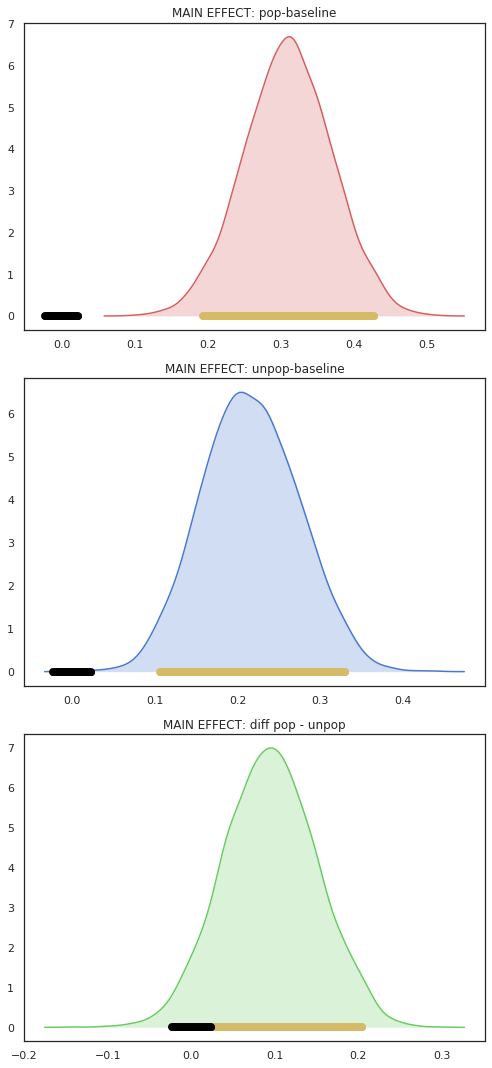

In [98]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

fit_df_2 = fit_3dprime_interaction_full.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=129
NxWithinLvl=3
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxW = np.zeros((NxSubjectLvl, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        exec('mu = fit_df_2["a0"] + fit_df_2["aCondition[{}]"] + fit_df_2["aS[{}]"]'.format(i+1,k+1))
        mSxW[k,i,:] = mu

# Convert to masked array that masks value '0'.
mSxW_ma = ma.masked_equal(mSxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W
mS = ma.mean(mSxW_ma, axis=(1))
print('ms shape')
print(mS.data.shape)
mW = ma.mean(mSxW_ma, axis=(0))
print('mW shape')
print(mW.data.shape)

# Equation 20.3
m = ma.mean(mSxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.7
bS = mS.squeeze() - m

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1


z=0
for i in mdiff_pop_unpop1:
    if i>.023:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(pop_diff))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)


rope=0.023

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(3, 1, figsize=(7, 15),sharex=False)

ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


plt.tight_layout()
plt.show()


# Compute contrasts and visualize results for Individual Value model

percentage of parameters above 0 = 0.9665



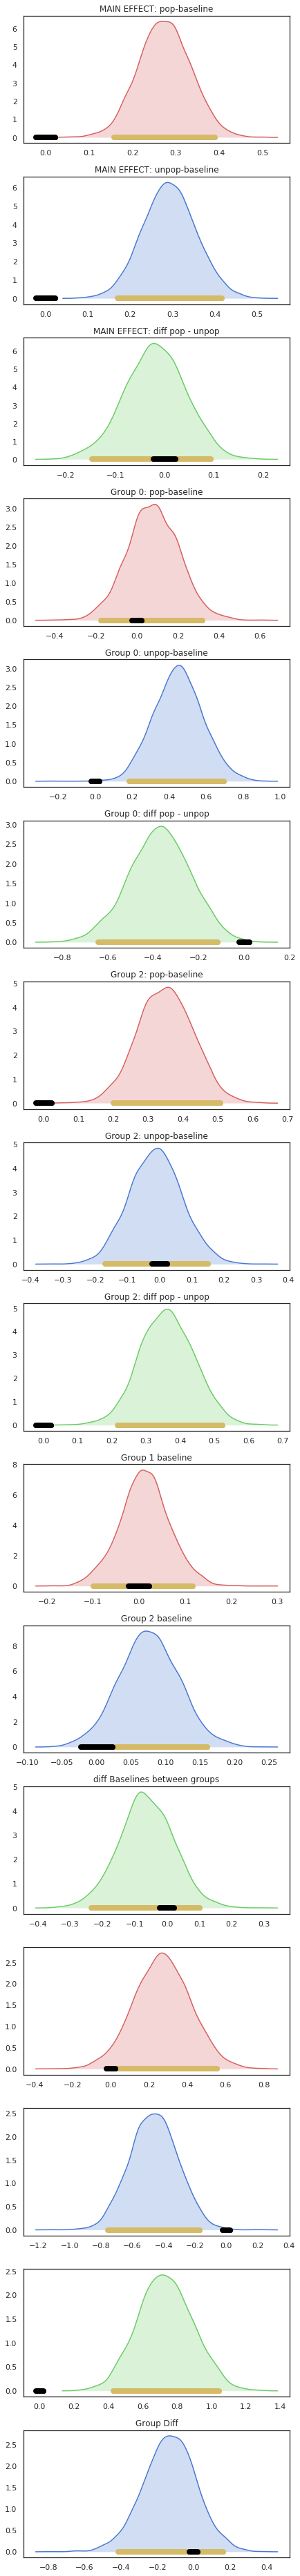

In [88]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

fit_df_2 = fit_3dprime_interaction_full_three.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=129
NxBetweenLvl=3
NxWithinLvl=3
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxBxW = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(NxBetweenLvl):
            exec('mu = fit_df_2["a0"]+ fit_df_2["aGroup[{}]"] + fit_df_2["aCondition[{}]"] + fit_df_2["aInteraction[{},{}]"] + fit_df_2["aS[{}]"]'.format(j+1,i+1,i+1,j+1,k+1))
            mSxBxW[k,j,i,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
# print('ms shape')
# print(mS.data.shape)

# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
# print('mBxW shape')
# print(mBxW.data.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
# print('mb shape')
# print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
# print('mw shape')
# print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

group1=bB[0,:]
group2=bB[1,:]
group3=bB[2,:]

base1 = bBxW[0,0,:]
pop1 = bBxW[0,1,:]
unpop1 = bBxW[0,2,:]

pop_dBase1 = (pop1+mpop1)-(base1+mbase1)
unpop_dBase1 = (munpop1+unpop1)-(base1+mbase1)
diff_pop_unpop1 = pop_dBase1-unpop_dBase1

base2 = bBxW[2,0,:]
pop2 = bBxW[2,1,:]
unpop2 = bBxW[2,2,:]

pop_dBase2 = (pop2+mpop1)-(base2+mbase1)
unpop_dBase2 = (munpop1+unpop2)-(base2+mbase1)
diff_pop_unpop2 = pop_dBase2-unpop_dBase2
diff_base=(base1+mbase1)-(base2+mbase1)


base_eq = bBxW[1,0,:]
pop_eq = bBxW[1,1,:]
unpop_eq = bBxW[1,2,:]

pop_dBaseE = (pop_eq+mpop1)-(base_eq+mbase1)
unpop_dBaseE = (munpop1+unpop_eq)-(base_eq+mbase1)
diff_pop_unpopE = pop_dBaseE-unpop_dBaseE

pop_diff=pop_dBase2-pop_dBase1
unpop_diff=unpop_dBase2-unpop_dBase1
diff_effect=diff_pop_unpop2-diff_pop_unpop1
group_diff=group1-group2
z=0
for i in pop_diff:
    if i>0:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(pop_diff))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)

l_ct, r_ct = highest_density_interval(pop_dBase1)
l_cp, r_cp = highest_density_interval(unpop_dBase1)
l_d, r_d = highest_density_interval(diff_pop_unpop1)

hl_ct, hr_ct = highest_density_interval(pop_dBase2)
hl_cp, hr_cp = highest_density_interval(unpop_dBase2)
hl_d, hr_d = highest_density_interval(diff_pop_unpop2)
hl_dr, hr_dr = highest_density_interval(diff_base)
lf,bf = highest_density_interval(base1)
la,ba= highest_density_interval(base2)


zhl_ct, zhr_ct = highest_density_interval(pop_diff)
zhl_cp, zhr_cp = highest_density_interval(unpop_diff)
zhl_cr, zhr_cr = highest_density_interval(diff_effect)

zhl_cf, zhr_cf = highest_density_interval(group_diff)

rope=0.023

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(16, 1, figsize=(6.2, 52),sharex=False)

ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(pop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[3])
ax0.set(title='Group 0: pop-baseline',xlabel='')

axs[3].plot([l_ct, r_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(unpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[4])
ax1.set(title='Group 0: unpop-baseline',xlabel='')

axs[4].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[5])
ax1.set(title='Group 0: diff pop - unpop',xlabel='')

axs[5].plot([l_d, r_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(pop_dBase2, hist=False,kde_kws={"shade": True},color="r", ax=axs[6])
ax0.set(title='Group 2: pop-baseline',xlabel='')

axs[6].plot([hl_ct, hr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[6].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(unpop_dBase2, hist=False,kde_kws={"shade": True},color="b", ax=axs[7])
ax1.set(title='Group 2: unpop-baseline',xlabel='')

axs[7].plot([hl_cp, hr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_pop_unpop2, hist=False,kde_kws={"shade": True},color="g", ax=axs[8])
ax1.set(title='Group 2: diff pop - unpop',xlabel='')

axs[8].plot([hl_d, hr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(base1, hist=False,kde_kws={"shade": True},color="r", ax=axs[9])
ax0.set(title='Group 1 baseline',xlabel='')

axs[9].plot([lf, bf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[9].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(base2, hist=False,kde_kws={"shade": True},color="b", ax=axs[10])
ax1.set(title='Group 2 baseline',xlabel='')

axs[10].plot([la, ba],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[10].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_base, hist=False,kde_kws={"shade": True},color="g", ax=axs[11])
ax1.set(title='diff Baselines between groups',xlabel='')

axs[11].plot([hl_dr, hr_dr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[11].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(pop_diff, hist=False,kde_kws={"shade": True},color="r", ax=axs[12])
# ax0.set(title='Group 2 - Group 1 on Popular',xlabel='')

axs[12].plot([zhl_ct, zhr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[12].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(unpop_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[13])
# ax0.set(title='Group 2 - Group 1 on Unpopular',xlabel='')

axs[13].plot([zhl_cp, zhr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[13].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(diff_effect, hist=False,kde_kws={"shade": True},color="g", ax=axs[14])
# ax0.set(title='Group 2 - Group 1 on Effect of Popularity',xlabel='')

axs[14].plot([zhl_cr, zhr_cr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[14].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(group_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[15])
ax1.set(title='Group Diff',xlabel='')

axs[15].plot([zhl_cf, zhr_cf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[15].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')




plt.tight_layout()
plt.show()


percentage of parameters above 0 = 0.9685



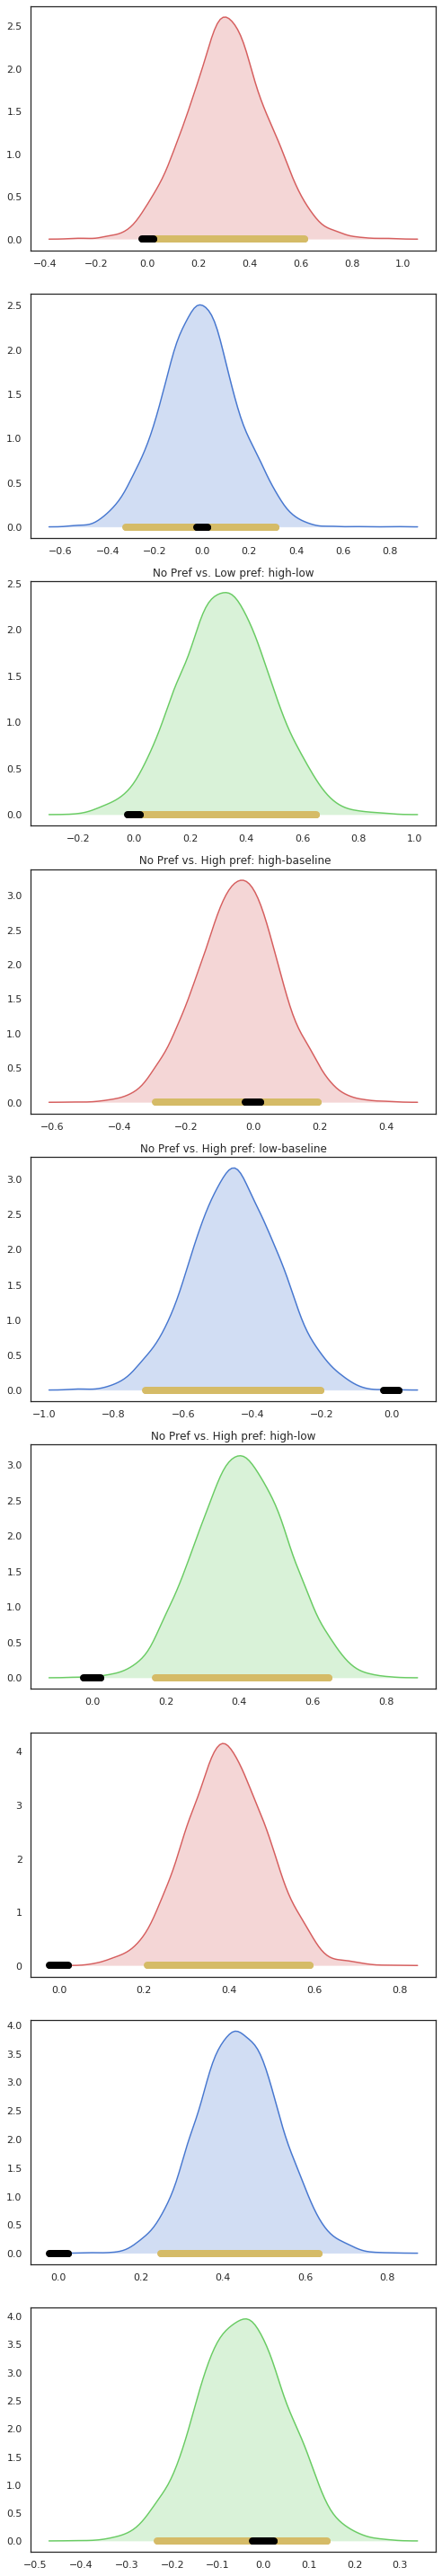

In [99]:

pop_diff2=pop_dBaseE-pop_dBase1
unpop_diff2=unpop_dBaseE-unpop_dBase1
diff_effect2=diff_pop_unpopE-diff_pop_unpop1

ml_c, mr_c = highest_density_interval(pop_diff2)
ml_r, mr_r = highest_density_interval(unpop_diff2)
ml_, mr_ = highest_density_interval(diff_effect2)
z=0
for i in diff_effect2:
    if i>rope:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(diff_effect2))))
print('')

f, axs = plt.subplots(9, 1, figsize=(7, 40),sharex=False)

ax0=sns.distplot(pop_diff2, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
# ax0.set(title=' No Pref vs. Low pref: high-baseline',xlabel='')

axs[0].plot([ml_c, mr_c],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(unpop_diff2, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
# ax0.set(title='No Pref vs. Low pref: low-baseline',xlabel='')

axs[1].plot([ml_r, mr_r],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(diff_effect2, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax0.set(title='No Pref vs. Low pref: high-low',xlabel='')

axs[2].plot([ml_, mr_],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

pop_diff3=pop_dBase2-pop_dBaseE
unpop_diff3=unpop_dBase2-unpop_dBaseE
diff_effect3=diff_pop_unpop2-diff_pop_unpopE

ml_p, mr_p = highest_density_interval(pop_diff3)
ml_f, mr_f = highest_density_interval(unpop_diff3)
ml_x, mr_x = highest_density_interval(diff_effect3)


ax0=sns.distplot(pop_diff3, hist=False,kde_kws={"shade": True},color="r", ax=axs[3])
ax0.set(title=' No Pref vs. High pref: high-baseline',xlabel='')

axs[3].plot([ml_p, mr_p],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(unpop_diff3, hist=False,kde_kws={"shade": True},color="b", ax=axs[4])
ax0.set(title='No Pref vs. High pref: low-baseline',xlabel='')

axs[4].plot([ml_f, mr_f],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(diff_effect3, hist=False,kde_kws={"shade": True},color="g", ax=axs[5])
ax0.set(title='No Pref vs. High pref: high-low',xlabel='')

axs[5].plot([ml_x, mr_x],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

pop_diffE=pop_dBaseE
unpop_diffE=unpop_dBaseE
diff_effectE=diff_pop_unpopE

ml_q, mr_q = highest_density_interval(pop_diffE)
ml_l, mr_l = highest_density_interval(unpop_diffE)
ml_v, mr_v = highest_density_interval(diff_effectE)


ax0=sns.distplot(pop_diffE, hist=False,kde_kws={"shade": True},color="r", ax=axs[6])
# ax0.set(title=' No Pref: high-baseline',xlabel='')

axs[6].plot([ml_q, mr_q],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[6].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(unpop_diffE, hist=False,kde_kws={"shade": True},color="b", ax=axs[7])
# ax0.set(title='No Pref: low-baseline',xlabel='')

axs[7].plot([ml_l, mr_l],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(diff_effectE, hist=False,kde_kws={"shade": True},color="g", ax=axs[8])
# ax0.set(title='No Pref: high-low',xlabel='')

axs[8].plot([ml_v, mr_v],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

plt.tight_layout()
plt.show()